# KNN-Classifier

In [1]:
# Import Packages
from Code.find_path_nextcloud import find_path_nextcloud
import matplotlib.pyplot as plt
import spectral as spy
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.metrics import confusion_matrix
import time

In [2]:
path_nextcloud = find_path_nextcloud()
path_labeled = path_nextcloud + 'Daten_Gyrocopter/Oldenburg/Teilbilder/grid_200_200/labeled/'

Daten als DataFrame einlesen

In [3]:
from Code.functions.import_labeled_data import import_labeled_data
from Code.functions.class_ids import get_class_dictionary, new_label_mapping
df_annotations = import_labeled_data(path_labeled_folder=path_labeled)

df_annotations = new_label_mapping(datafrane=df_annotations, map_column='label', label_mapping='Ohne_Auto_See')

class_dict = get_class_dictionary()
df_annotations['label'] = df_annotations['label'].replace(class_dict)

In [4]:
df_annotations.iloc[:3,:5]

,hsi_band_430_nm,hsi_band_434_nm,hsi_band_439_nm,hsi_band_443_nm,hsi_band_448_nm
0,1314.0,1369.0,1487.0,1572.0,1614.0
1,1301.0,1389.0,1501.0,1557.0,1679.0
2,1362.0,1494.0,1543.0,1546.0,1649.0


In [5]:
df_annotations.iloc[:3,-5:]

,hsi_band_925_nm,thermal,dom,label,picture_name
0,2554.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
1,2551.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
2,2579.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_


Aufteilung in Trainings- und Testdaten

In [6]:
X = df_annotations.drop(columns=['label', 'picture_name'])
Y = df_annotations['label']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print(f'X_train Shape: {len(X_train)}\nX_test Shape: {len(X_test)}\ny_train Shape: {len(y_train)}\ny_test Shape:{len(y_test)}')

X_train Shape: 924000
X_test Shape: 396000
y_train Shape: 924000
y_test Shape:396000


## KNN

Laufzeit: 5815.4s
Accuracy: 71.16944444444444
              precision    recall  f1-score   support

        Haus       0.79      0.80      0.80     91559
        None       0.64      0.63      0.63     96783
    Schienen       0.84      0.52      0.64      6246
      Strase       0.67      0.63      0.65     47542
        Wald       0.70      0.88      0.78     81588
       Wiese       0.75      0.59      0.66     72282

    accuracy                           0.71    396000
   macro avg       0.73      0.67      0.69    396000
weighted avg       0.71      0.71      0.71    396000



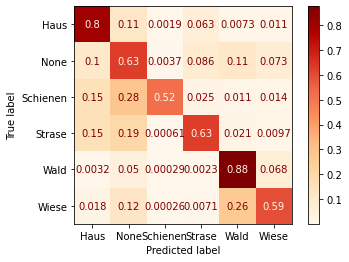

In [7]:
# save start time
start = time.process_time()

# Train
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Test
knn_pred = knn.predict(X_test)

# save end time
end = time.process_time()

# calculate runtime
run_time = end - start


# Result
print(f'Laufzeit: {run_time.__round__(1)}s')
print(f"Accuracy: {accuracy_score(y_test, knn_pred) * 100}")
print(classification_report(y_test, knn_pred))

cm = confusion_matrix(y_test, knn_pred, labels=list(unique(knn_pred)), normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=list(unique(knn_pred)))
disp.plot(cmap="OrRd")
plt.show()

### KNN mit Grid-Search

In [10]:
from sklearn.model_selection import GridSearchCV
import time

In [11]:
parameters = {'n_neighbors':[1,5,10,20,30], 'weights':['uniform', 'distance'], 'p':[2]}

classifier = GridSearchCV(estimator = KNeighborsClassifier(n_jobs=5),
                          param_grid = parameters,
                          scoring = "f1_macro",
                          n_jobs = 6,
                          refit = True,
                          cv = 2, # Crossvalidation k-folds
                          verbose = 3,
                          pre_dispatch ='2*n_jobs',
                          error_score = np.nan,
                          return_train_score = False)


In [ ]:
start = time.process_time()
classifier.fit(X=X, y=Y)
end = time.process_time()

run_time = end - start
print(f'Laufzeit: {run_time.__round__(1)}s')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [13]:
df = pd.DataFrame(classifier.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.979184,0.010469,1396.597473,18.642152,1,2,uniform,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.547485,0.575717,0.561601,0.014116,9
1,2.023572,0.027944,1363.865004,41.031280,1,2,distance,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",0.547485,0.575717,0.561601,0.014116,9
2,2.112352,0.120678,1351.799765,22.754651,5,2,uniform,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.562000,0.607505,0.584753,0.022753,8
3,2.453942,0.031415,1359.034916,32.813254,5,2,distance,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.569603,0.610203,0.589903,0.020300,7
4,2.500812,0.069314,1384.970073,26.073777,10,2,uniform,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.573162,0.623712,0.598437,0.025275,6


In [18]:
df.to_csv(path_or_buf='data/KNN_GridSearch.csv', sep=';', encoding='utf8')

In [19]:
classifier.best_estimator_

KNeighborsClassifier(n_jobs=5, n_neighbors=20, weights='distance')

In [20]:
classifier.best_score_

0.6046059210693627